## Perform necessary imports and define global variables

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson
import scipy as sc
import re, random, math, time

# Define important global variables
number_of_simulations = 10
noise_ratio = 0.95
number_of_orders = 100
num_poisson_small = 10000  #number of small order quantities to generate prior to sampling
num_poisson_large = 500    #number of large order quantities to generate prior to sampling

# Pull in our file containing product info - Finished Goods and corresponding Parts
df_parts = pd.read_csv('finished_good_parts.csv')

## Create Simulated orders 

In [2]:
s = np.random.poisson(1, num_poisson_small)+1

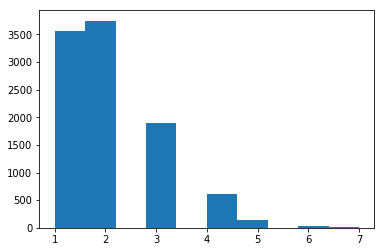

10000

In [3]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 10)
plt.show()
len(s)


In [4]:
# Generate list of integers 1-number_of_orders to use as identifying ORDER NUMBER's
order_number = np.arange(1,(number_of_orders+1))
# Generate random list of integers (1-5) as the FINISHED GOOD purchased in each order
FG = [random.randrange(1, 6, 1) for _ in range(number_of_orders)]

'''
Generate order QUANTITIES (number of Finished Good ordered).
Due to strange poisson distribution we are trying to emulate we build 2 distributions:
s - list of smaller order quantities to represent personal orders, w/ poisson dist centered around 3
s_larger - list of larger order quantities to represent company orders, w/ poisson dist centered around 50
'''
s = np.random.poisson(2, num_poisson_small)  
s_larger = np.random.poisson(50, num_poisson_large)

# Combine our 2 sets and remove all quantities equal to 0
s_combined = [*s,*s_larger]
s_combined[:]=(value for value in s_combined if value != 0)

# Take a random sample of size (number_of_orders) from our poisson distribution of order QUANTITIES
order_quantities = np.random.choice(s_combined, number_of_orders, replace=False)

# Turn our 3 lists created above into a DataFrame
df_orders = pd.DataFrame({'Order Number':order_number, 'Finished Good':FG, 'Order Qty':order_quantities})

# Combine all of our ORDER and PART information into a full DataFrame of Simulated Order Information
df_full = df_orders.merge(df_parts, on="Finished Good", how="outer")

# Create new column 'qty_on_order' to show total number of parts required (some FG require 2 of the same part to build)
df_full['qty_on_order'] = df_full['Order Qty']*df_full['Quantity']
# Create null column 'fulfilled_parts' that will be updated later
df_full['fulfilled_parts'] = np.nan

## Simulate inventory levels using our noise_ratio

In [5]:
# Make new DataFrame to simulate inventory on hand
df_inventory = df_full.groupby('Item_Number')[['qty_on_order']].sum()
df_inventory.reset_index(level=0, inplace=True)
# SUM up the qty_on_order grouped by each Item_Number and multiply by noise_ratio for 'Inventory' levels
df_inventory['Inventory'] = df_inventory['qty_on_order'].apply(lambda x: math.ceil (x*noise_ratio))
df_inventory.head()

,Item_Number,qty_on_order,Inventory
0,000000000000008820,88,84
1,000000000000011977,100,95
2,000000000025216222,193,184
3,000000000031028400,110,105
4,000000000031028776,88,84


## Attempt to fulfill our orders

In [6]:
start_time = time.time()

'''
Loop through our orders sequentially and attempt to fulfill orders part-by-part.
Compare the qty_on_order of each part to our inventory levels of that part (or Item_Number).
If there are enough parts in inventory set 'fulfilled_parts' to True, and subtract required
qty_on_order from our current inventory.
Otherwise set our 'fulfilled_parts' to False, and do NOT attempt to deplete inventory levels.
'''
for i in range(1,(number_of_orders+1)):
    # Find all parts and required quantities for Order Number i (1 through 100) 
    current_order = df_full[df_full['Order Number'] == i]
    # Iterate through each part on the current_order
    for j in range(len(current_order)):
        part = current_order.iloc[j]['Item_Number']
        qty = current_order.iloc[j]['qty_on_order']
        on_hand = df_inventory['Inventory'][df_inventory['Item_Number']==part].values[0]
        # Check to see if we have enough parts on hand
        if ((on_hand - qty) > 0):
            # if so set new column ('Fulfilled') to True
            df_full.loc[(df_full['Order Number']==i) & (df_full['Item_Number']==part),'fulfilled_parts'] = True
            # subtract qty (quantity of current part for the current order) from inventory on hand
            df_inventory.loc[df_inventory['Item_Number']==part, 'Inventory'] = df_inventory['Inventory'][df_inventory['Item_Number']==part] - qty
            #print(df_parts['Inventory'][df_parts['Item_Number']==part])

        # If we don't have enough parts set 'Fulfilled' value to False
        else:
            df_full.loc[(df_full['Order Number']==i) & (df_full['Item_Number']==part),'fulfilled_parts'] = False

print("--- %s seconds ---" % (time.time() - start_time))

--- 34.315211057662964 seconds ---


In [22]:
# Save to csv to view ALL values in excel or w/e
#df_full.sort_values(by='Order Number')#.to_csv('fulfilled_simulation.csv')
#df_full.head()

In [23]:
# Show remaining inventory --> since I don't remove if qty can't be fulfilled there will be a couple leftovers for each part
#df_parts.head()

# Serviceabilities
### Finished Good Level
- Cell below groups data by Order Number and checks the mean of fulfilled_parts (T/F values)
- If mean value is less than 1 (i.e. order can not be fulfilled) set to 0
- Next group by FG and find mean value of above to get serviceability: 
  - <b>FGS = (% of Entire orders fulfilled)</b>
<p>
- <b>Do we need to account for quantities of FG ordered?</b>

In [7]:
# REPLACE n with our trial number once wrapped in function
sim_number = 1
col_name = "FGS_"+str(sim_number).zfill(3)

# Group by Order Number and Finished Good and get average of fulfilled_parts column
fg_fulfillment = df_full.groupby(['Order Number', 'Finished Good'])[['fulfilled_parts']].mean()
fg_fulfillment.reset_index(level=1, inplace=True)
fg_fulfillment.reset_index(level=0, inplace=True)

# Set all 'fulfilled_parts' values less than 1 equal to 0 (i.e. order cannot be fully fulfilled/machine not built)
fg_fulfillment.loc[(fg_fulfillment['fulfilled_parts'] < 1), 'fulfilled_parts'] = 0
fg_serviceability = fg_fulfillment.groupby('Finished Good')[['fulfilled_parts']].mean()

# Clean up dateframe, rename column
fg_serviceability.reset_index(level=0, inplace=True)
fg_serviceability = fg_serviceability.rename(columns={"fulfilled_parts":col_name})
fg_serviceability

,Finished Good,FGS_001
0,1,0.666667
1,2,0.769231
2,3,0.894737
3,4,0.818182
4,5,0.952381


### Part Level
- We only have T/F values based on whether the TOTAL number (qty_on_order) can be fulfilled
- Simply group by parts (Item_Number) and take mean

In [11]:
col_name = "PTS_" + str(sim_number).zfill(3)

pt_serviceability = df_full.groupby(['Finished Good','Item_Number'])[['fulfilled_parts']].mean()

# Clean up DataFrame and rename column (Allows for multiple columns based on trial/simulation number)
#pt_serviceability.reset_index(level=0, inplace=True)

#pt_serviceability = pt_serviceability.rename(columns={"fulfilled_parts":col_name})
#pt_serviceability

pt_new = df_full.groupby(['Finished Good','Item_Number'])[['fulfilled_parts']].mean()
pt_new.reset_index(level=0, inplace=True)

In [12]:
pt_serviceability = pt_serviceability.merge(pt_new, on=['Finished Good','Item_Number'], how='outer')
pt_serviceability = pt_serviceability.rename(columns={"fulfilled_parts":'PTS2'})
pt_serviceability

,Finished Good,fulfilled_parts_x,fulfilled_parts_y
Item_Number,,,
000000000000008820,1,0.666667,0.666667
000000000031028776,1,0.666667,0.666667
000000000031034609,1,0.666667,0.666667
000000000031034776,1,0.666667,0.666667
000000000031037296,1,0.666667,0.666667
000000000031040179,1,0.666667,0.666667
000000000031045548,1,0.666667,0.666667
000000000031045550,1,0.666667,0.666667
000000000031503985,1,0.666667,0.666667


## Probability Distributions of our fg_ & pt_serviceability